In [60]:
import numpy as np
import pandas as pd
import fastavro
from river import time_series, linear_model, metrics, preprocessing, optim, compose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import pytz
import copy

In [2]:
# Function to read Avro file into a Pandas DataFrame
def read_avro(file_path):
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        records = [record for record in avro_reader]
    return pd.DataFrame(records)

# Example usage
file_path = 'weatherbatch.avro'
df = read_avro(file_path)
print(df.head())

           dt  temp  pressure  humidity  wind_speed  wind_deg  precipitation  \
0  1706742000  4.21      1024        83        2.57       220            0.0   
1  1706745600  3.57      1023        83        4.12       230            0.0   
2  1706749200  2.59      1022        86        3.13       233            0.0   
3  1706752800  1.70      1021        88        4.02       209            0.0   
4  1706756400  1.03      1020        91        3.58       227            0.0   

   clouds  
0     100  
1      40  
2      20  
3      20  
4      40  


In [26]:
def logit100(x):
    return np.log(x / (100 - x))
def sigmoid100(x):
    return 100 / (1 + np.exp(-x))

In [3]:
n = df.shape[0] * 4 - 3
df_extra = pd.DataFrame(np.nan, index=range(n), columns=df.columns)

In [4]:
for i in range(df.shape[0]-1):
    df_extra.iloc[4*i] = df.iloc[i]
    diff = (df.iloc[i+1] - df.iloc[i]) / 4
    for j in range(1, 4):
        df_extra.iloc[4*i+j] = df_extra.iloc[4*i+j-1] + diff
df_extra.iloc[-1] = df.iloc[-1]

In [ ]:
{"precipitation":"0.23999999463558197","latitude":"51.75","cloud_coverage":"75","name":"Łódź","temperature":"279.64","humidity":"86","wind_speed":"3.58","wind_direction":"184","pressure":"1004","longitude":"19.45","timestamp":"1736248059"}

In [5]:
df_extra['dt'] = df_extra['dt'].astype(int)
df_extra['pressure'] = df_extra['pressure'].round().astype(int)
df_extra['humidity'] = df_extra['humidity'].round().astype(int)
df_extra['wind_deg'] = df_extra['wind_deg'].round().astype(int)
df_extra['clouds'] = df_extra['clouds'].round().astype(int)

In [145]:
df_extra.head()

,dt,temp,pressure,humidity,wind_speed,wind_deg,precipitation,clouds
0,1706742000,4.21,1024,83,2.5700,220,0.0,100
1,1706742900,4.05,1024,83,2.9575,222,0.0,85
2,1706743800,3.89,1024,83,3.3450,225,0.0,70
3,1706744700,3.73,1023,83,3.7325,228,0.0,55
4,1706745600,3.57,1023,83,4.1200,230,0.0,40


In [6]:
def unix_to_hour_pol(time):
    poland_tz = pytz.timezone('Europe/Warsaw')
    return datetime.datetime.fromtimestamp(time, poland_tz).hour

In [7]:
X = df_extra.drop(columns=["clouds"])
X['dt'] = X['dt'].apply(unix_to_hour_pol) #[unix_to_hour_pol(x) for x in X[:,0]]
y = df_extra["clouds"]


## Basic model, one year

In [25]:
model = time_series.SNARIMAX(
    p=1,
    d=1,
    q=1,
    sp=1,
    sd=1,
    sq=1,
    m=4*24 # daily seasonality
)

forecasts = []
for i in range(X.shape[0]-24*4-24*4):#-24*4*7
    #x = X.iloc[i].to_dict()
    target = y.iloc[i+24*4]
    model.learn_one(target)#, x)
    forecasts.append(model.forecast(1))

forecasts = np.array(forecasts).flatten()

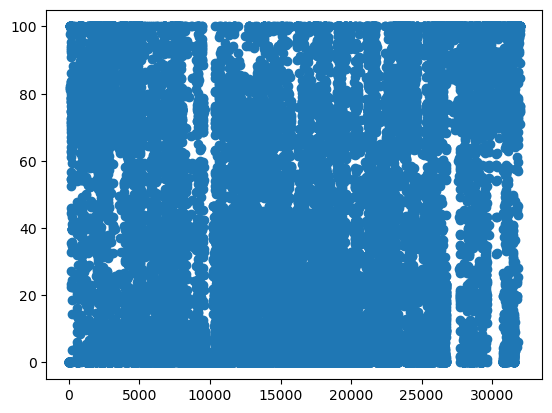

In [ ]:
# just checking if the model didn't start to give totally wrong values (that would be the case if there where only 0s or 100s)
plt.scatter(range(len(forecasts)), np.clip(forecasts, 0, 100))

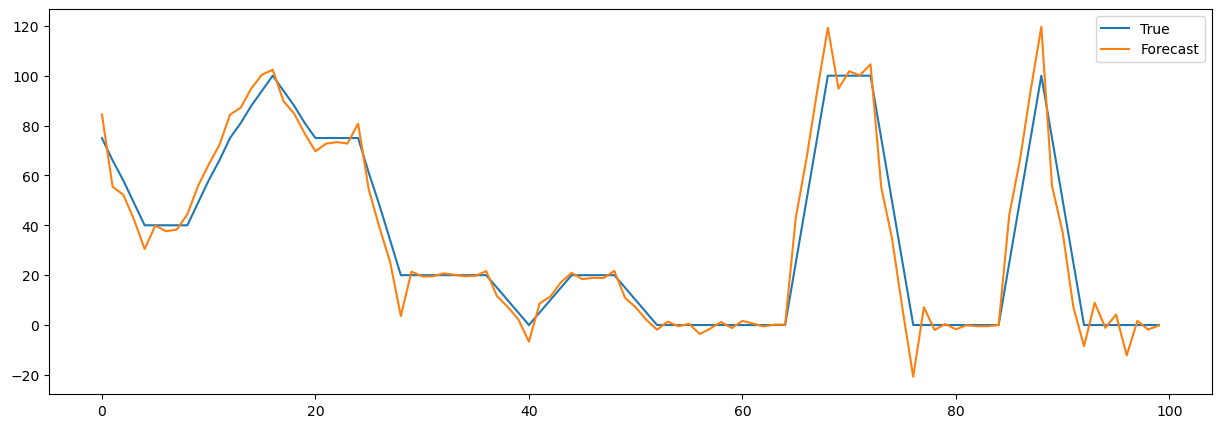

In [ ]:
# checking some random values
s = 15000
e = 15100
plt.figure(figsize=(15, 5))
plt.plot(y.values[s+4*24:e+4*24], label='True')
plt.plot(forecasts[s:e], label='Forecast')
plt.legend()
plt.show()

## Evaluation

### Batch training

In [43]:
Xtrain = X.iloc[:-24*4*7]
ytrain = y.iloc[:-24*4*7]

model = time_series.SNARIMAX(
    p=1,
    d=1,
    q=1,
    sp=1,
    sd=1,
    sq=1,
    m=4*24 # daily seasonality
)

forecasts = []
for i in range(Xtrain.shape[0]-24*4):#-24*4*7
    #x = Xtrain.iloc[i].to_dict()
    target = ytrain.iloc[i+24*4]
    model.learn_one(target)

### Simulation of online training for a week

In [97]:
model_online = copy.deepcopy(model)
Xtest = X.iloc[-24*4*7:]
ytest = y.iloc[-24*4*7:]
forecasts = []
for i in range(24*4*7):
    model_online.learn_one(ytest.iloc[i])
    forecast = np.clip(np.array(model_online.forecast(4*24)), 0, 100)
    forecast = forecast.reshape(-1, 4).mean(axis=1)
    forecasts.append(forecast)

### Results

In [99]:
forecasts[0]

array([ 99.51783504,  98.62635291,  91.96624995,  95.29901292,
        93.61350152,  96.71580426, 100.        ,  98.97408581,
        97.59087452,  97.76746003,  99.14505762,  99.80524756,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ])

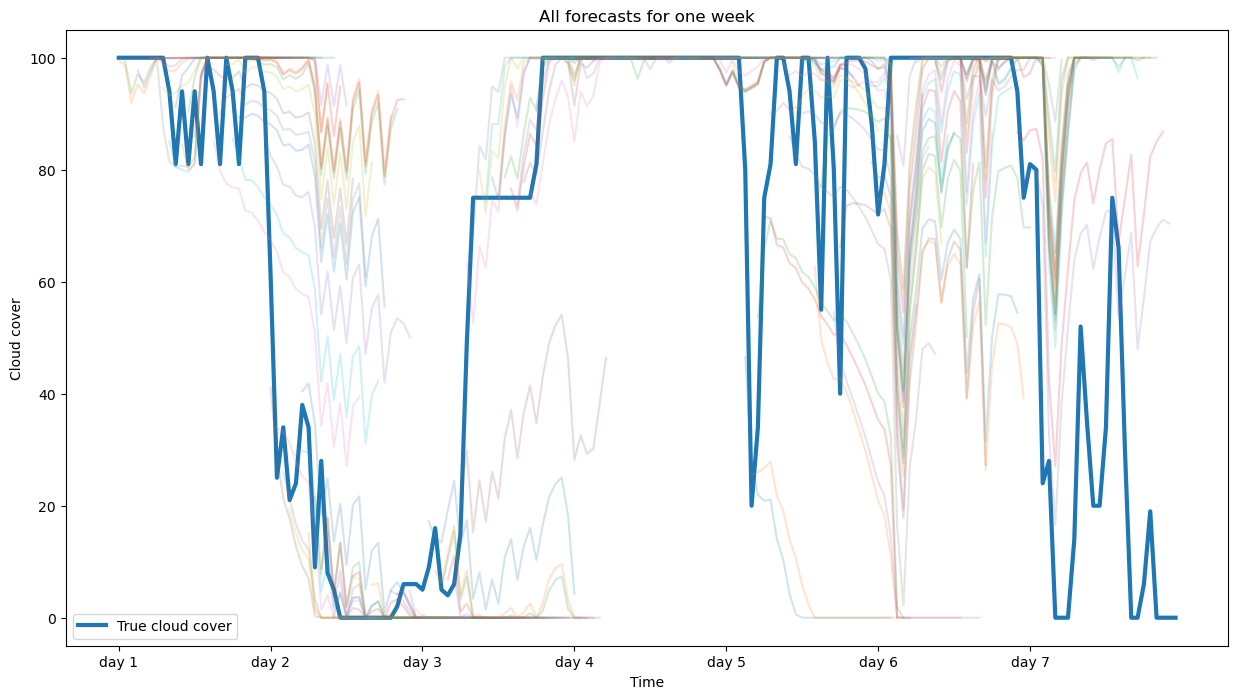

In [111]:
plt.figure(figsize=(15, 8))
plt.plot(ytest[::4].values, label='True cloud cover', linewidth=3)
for i in range(24*6):
    plt.plot(range(i, i+24), forecasts[i*4], alpha=0.2)
plt.legend()
plt.title('All forecasts for one week')
plt.xlabel('Time')
plt.ylabel('Cloud cover')
plt.xticks(range(0, 24*7, 24), [f"day {i}" for i in range(1, 8)])
plt.show()

In [105]:
y1h = ytest[::4].values
errors = np.zeros(24)
for i in range(24*7):
    for j in range(4):
        errors += np.abs(forecasts[i*4+j] - y1h[i])
    
errors /= 24*4*7

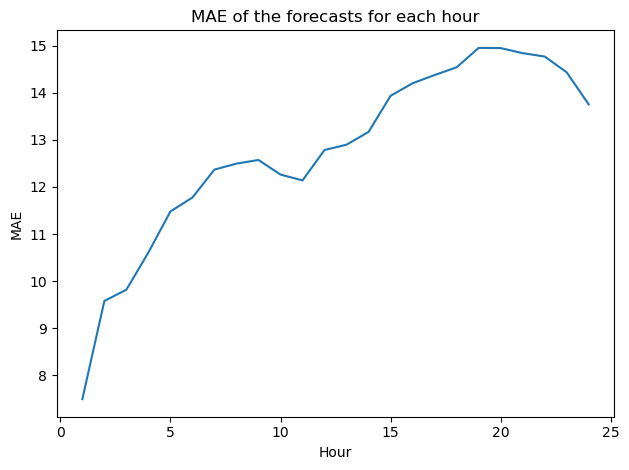

In [110]:
plt.plot(range(1, 25), errors)
plt.xlabel('Hour')
plt.ylabel('MAE')
plt.title('MAE of the forecasts for each hour')
#plt.legend()
plt.tight_layout()
plt.show()

## Updating model

In [ ]:
def get_model():
    pass
def get_data():
    pass
def send_forecast():
    pass
def save_model():
    pass
def preprocess_data(x,y):
    pass

In [162]:
x, y = get_data()
model = get_model()
x,y = preprocess_data(x, y)
model.learn_one(y, x)
forecast = model.forecast()
send_forecast(forecast)
save_model(model)

In [160]:
y_new = y.values[-24*4] # new data from kafka
x_new = X.iloc[-24*4].to_dict() # new data from kafka

In [163]:
model.learn_one(y_new, x_new)

In [ ]:
model.forecast(24*4, x_new)

In [164]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)